## Time evolving leaf CN vs CO2

- this notebook analyzes global runs of CLM data for 3 cases:
  - Relationship between leaf CN and CO2 has a slope of 20
  - Control case where CN vs CO2 has slope 0
  - CLM leaf CN flexibility parameter is altered

First read in necessary packages: 

In [25]:
#Load necessary packages for data visualization 
import xarray as xr
from ctsm_py import utils
#import utils
import numpy as np
import pandas as pd
from netCDF4 import num2date
import dask 

#some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os,sys
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

%matplotlib inline


In [2]:
xr.__version__

'2022.3.0'

In [3]:
# User defined options
model = 'CLM5_GSWP3'

archive = '/glade/scratch/wwieder/archive/'
caseShort = ['cnSlope0', 'cnSlope20', 'cn_flex_c']
cases = ['ctsm51d074_2deg_GSWP3V1_hist_'+short for short in caseShort]
path = '/lnd/hist/'
fin = [archive + case + path + "concat/" + case + '_cat.nc' for case in cases]
print(fin[0])

# Read in files for .area and .landfrac
fin2 = [archive + case + path + case + '.clm2.h0.1850-01.nc' for case in cases]
print(fin2[0])

/glade/scratch/wwieder/archive/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0/lnd/hist/concat/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0_cat.nc
/glade/scratch/wwieder/archive/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0/lnd/hist/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0.clm2.h0.1850-01.nc


### Read in data

In [4]:
# Read in data, time and time_bounds just used for utils.time_set_mid
var = ['NPP', 'GPP', 'LEAFCN', 'EFLX_LH_TOT', 'TOTVEGC', 'ELAI', 'TOTLITC','TOTLITN','FPI', 'NET_NMIN', 'NFIX',
       'time', 'time_bounds']

'''select the variables we want to read in'''
def preprocess(ds, var=var):
    return ds[var]

# For slope 0
for i in range(len(cases)):
    dsIN = utils.time_set_mid(xr.open_mfdataset(fin[i], decode_times=True, preprocess = preprocess), 'time')
    LandDs = utils.time_set_mid(xr.open_mfdataset(fin2[i], decode_times=True), 'time')
    dsIN['area'] = LandDs.area
    dsIN['landfrac'] = LandDs.landfrac

    if i == 0:
        ds = dsIN
    else:
        ds = xr.concat([ds,dsIN],"case",data_vars='all')


ds = ds.assign_coords(case=("case", caseShort))
ds = ds[['NPP', 'GPP', 'LEAFCN', 'EFLX_LH_TOT', 'TOTVEGC', 'ELAI', 'TOTLITC','TOTLITN','NET_NMIN','FPI', 'NFIX']]
#ds = ds.load()  # this may make things really slow now, but hopefully faster later on
ds

<xarray.Dataset>
Dimensions:      (case: 3, time: 1980, lat: 96, lon: 144)
Coordinates:
  * time         (time) object 1850-01-16 11:44:59.999993 ... 2014-12-16 12:0...
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * case         (case) <U9 'cnSlope0' 'cnSlope20' 'cn_flex_c'
Data variables:
    NPP          (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    GPP          (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    LEAFCN       (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    EFLX_LH_TOT  (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    TOTVEGC      (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    ELAI         (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    TOTLITC      (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    TOTLITN      (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NET_NMIN     (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    FPI          (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NFIX         (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
Attributes: (12/100)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Apr 25 05:33:00 2022: ncrcat ct...
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    NCO:                                  netCDF Operators version 5.0.3 (Hom...

## Making time series plots and global maps
 - find annual averages
 - plot time series 
 - plot maps

#### Helpful notebooks for time series plotting
 - https://github.com/wwieder/ctsm_py/blob/master/notebooks/SimpleExample.ipynb
 - https://github.com/wwieder/ctsm_py/blob/master/notebooks/SimpleExampleNfix.ipynb
 - https://github.com/wwieder/cesm-lens/blob/main/notebooks/lens_NBP.ipynb

### Convert monthly to annual

<xarray.Dataset>
Dimensions:      (time: 165, lon: 144, lat: 96, case: 3)
Coordinates:
  * time         (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * case         (case) <U9 'cnSlope0' 'cnSlope20' 'cn_flex_c'
Data variables:
    NPP          (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    GPP          (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    LEAFCN       (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    EFLX_LH_TOT  (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    TOTVEGC      (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    ELAI         (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    TOTLITC      (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    TOTLITN      (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    NET_NMIN     (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    FPI          (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    NFIX         (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>

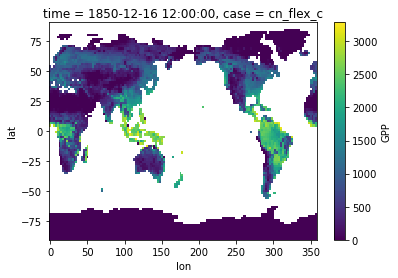

In [5]:
spy = 365 * 24 * 3600               # Convert  to annual fluxes (gC/m2/y), from gc/m2/s 
dsAnn = ds.apply(utils.weighted_annual_mean)
fluxes = ['GPP', 'NPP', 'NFIX', 'NET_NMIN']
for i in range(len(fluxes)):
    dsAnn[fluxes[i]] = dsAnn[fluxes[i]] * spy

dsAnn.GPP.isel(time=0, case=2).plot() ;
dsAnn

In [6]:
# this seems to take forever...
dsAnn = dsAnn.load()
print('loaded data to memory')

loaded data to memory


### Calculate CUE, 
where minimum of annual GPP > 10 

array([0.45414919, 0.45415849, 0.45937855])

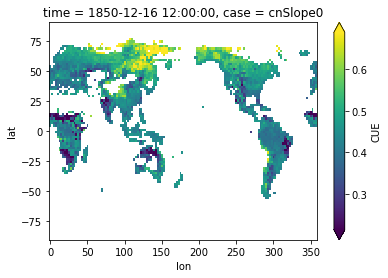

In [7]:
# sets minimum GPP, here 10 gC/m2/y,
# using a small value (> 0) prevents absure CUE calculations
minGPP = 10.
dsAnn['GPP'] = dsAnn.GPP.where(dsAnn.GPP.min('time') > minGPP)
dsAnn['CUE'] = dsAnn.NPP / dsAnn.GPP
dsAnn.CUE.isel(time=0, case=0).plot(robust=True)
dsAnn.CUE.mean(['lat', 'lon']).isel(time=0).values

### Calculate WUE

array([23.64567762, 23.63985643, 23.70129189])

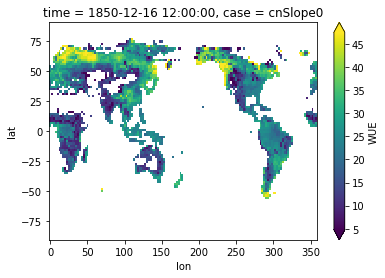

In [8]:
dsAnn['WUE'] = dsAnn.GPP / dsAnn.EFLX_LH_TOT
dsAnn.WUE.isel(time=0, case=0).plot(robust=True)
dsAnn.WUE.mean(['lat', 'lon']).isel(time=0).values

### Calculate Litter C:N

array([43.84121927, 43.84121927, 44.03651849])

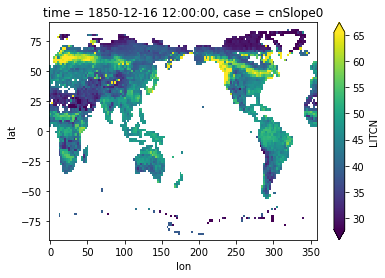

In [9]:
dsAnn['LITCN'] = dsAnn.TOTLITC / dsAnn.TOTLITN
#dsAnn.TOTMICN.values
dsAnn.LITCN.isel(time=0, case=0).plot(robust=True)
dsAnn.LITCN.mean(['lat', 'lon']).isel(time=10).values

### Check the time series 
gaps will appear if inf or -inf values are calculated

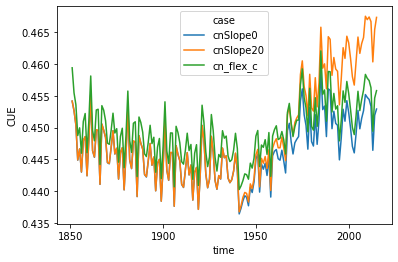

In [10]:
dsAnn.CUE.mean(['lat', 'lon']).plot(hue='case') ;
# Mask out absurd values if needed
# dsAnn['CUE'] = dsAnn.CUE.where(dsAnn.CUE > -1).where(dsAnn.CUE < 1)

### Make weights for global sum

sum area_wgt = 0.99999994


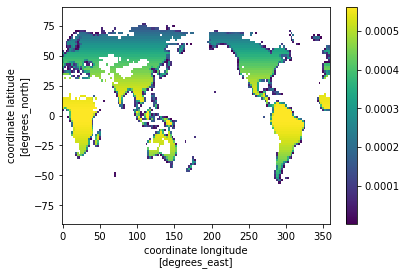

In [11]:
# only weight areas for grids with GPP>0
landUp = LandDs.area * LandDs.landfrac * 1e6      # area in km2, not m2
landUp = landUp.where(dsAnn.GPP.isel(case=0).min('time') > minGPP)
landUp.attrs['units'] = 'm^2'

# weighting for each grid cell
area_wgt = (landUp / landUp.sum()).drop('case')
area_wgt.plot()
print('sum area_wgt = '+ str(area_wgt.sum().values) )

### Calculate global sums

In [12]:
# ?? This could also be done regionally (see Paul's comments on google doc) ??
ann_glob = (dsAnn * landUp).sum(dim=('lat', 'lon'))

## 1 mm water = 1 kg/m2,  1e-15 for kg to Tt,  1e-15 gC to PgC,
# convert to Pg C/y, mm to Tt
Cvars = ['GPP','NPP','TOTVEGC', 'NFIX', 'NET_NMIN']
for i in range(len(Cvars)):
    ann_glob[Cvars[i]] = ann_glob[Cvars[i]] * 1e-15
    if Cvars[i] == 'TOTVEGC':
        ann_glob[Cvars[i]].attrs['units'] = 'Pg C'
    if Cvars[i] == ['NFIX', 'NET_NMIN']:
        ann_glob[Cvars[i]].attrs['units'] = 'Pg N'
    else:
        ann_glob[Cvars[i]].attrs['units'] = 'Pg C y^-1'

# area weighted mean
ann_Awgt = (dsAnn * area_wgt).sum(dim=('lat', 'lon'))


## Make a line plot

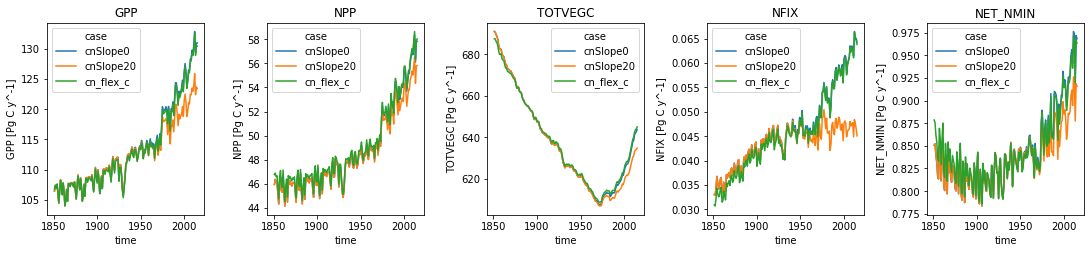

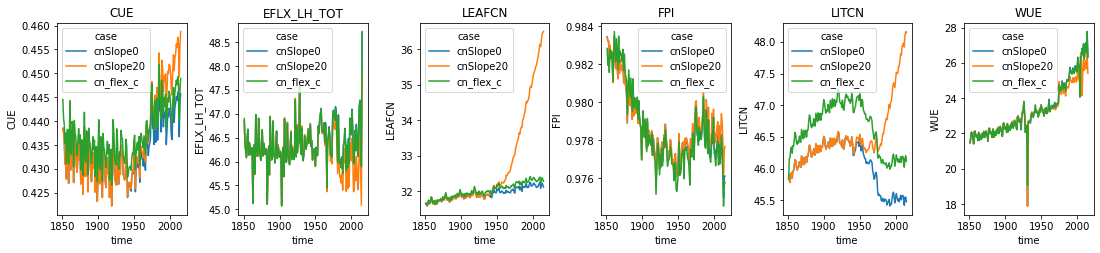

In [13]:
#quick plot , the `;` on the last line supresses text after executing the cell
vars = ['GPP', 'NPP', 'TOTVEGC', 'CUE', 'EFLX_LH_TOT', 'LEAFCN']
globVars = ['GPP', 'NPP', 'TOTVEGC', 'NFIX', 'NET_NMIN']
vars2 = ['CUE', 'EFLX_LH_TOT', 'LEAFCN', 'FPI', 'LITCN', 'WUE']

plt.figure(figsize=(18,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    ann_glob.get(globVars[i]).plot(hue='case')
    plt.title(globVars[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4);

plt.figure(figsize=(18,8))
for i in range(6):
    plt.subplot(2,6,1+i)
    ann_Awgt.get(vars2[i]).plot(hue='case')
    plt.title(vars2[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4);


    
# plt.subplot(232)
# ann_glob.NPP.plot(hue='case')


### Make plots without cn_flex_c case

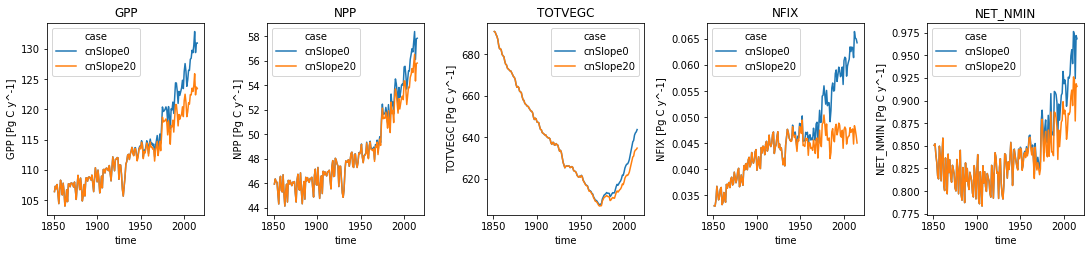

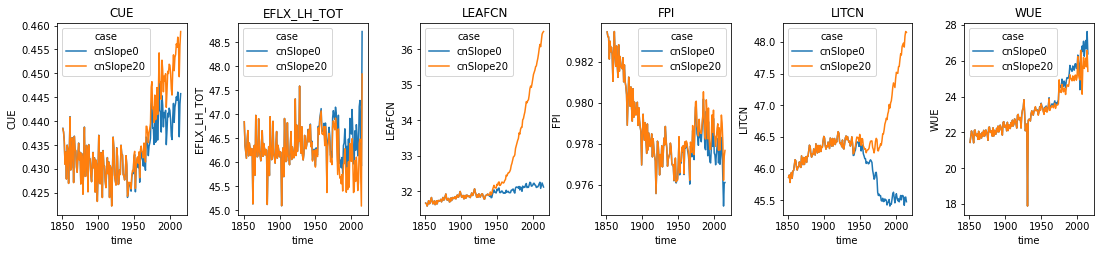

In [14]:
#quick plot , the `;` on the last line supresses text after executing the cell
vars = ['GPP', 'NPP', 'TOTVEGC', 'CUE', 'EFLX_LH_TOT', 'LEAFCN']
globVars = ['GPP', 'NPP', 'TOTVEGC', 'NFIX', 'NET_NMIN']
vars2 = ['CUE', 'EFLX_LH_TOT', 'LEAFCN', 'FPI', 'LITCN', 'WUE']
ann_glob_sub = ann_glob.isel(case = [0,1])
ann_Awgt_sub = ann_Awgt.isel(case = [0,1])


plt.figure(figsize=(18,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    ann_glob_sub.get(globVars[i]).plot(hue='case')
    plt.title(globVars[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4);

plt.figure(figsize=(18,8))
for i in range(6):
    plt.subplot(2,6,1+i)
    ann_Awgt_sub.get(vars2[i]).plot(hue='case')
    plt.title(vars2[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4);


    
# plt.subplot(232)
# ann_glob.NPP.plot(hue='case')



In [15]:
#ds.ELAI.where(ds.GPP.groupby('time.year').idxmax('time'))

### Make global difference maps
 - CUE
 - NPP
 - GPP
 - Total Veg C
 
 
For last 10 years of simulation


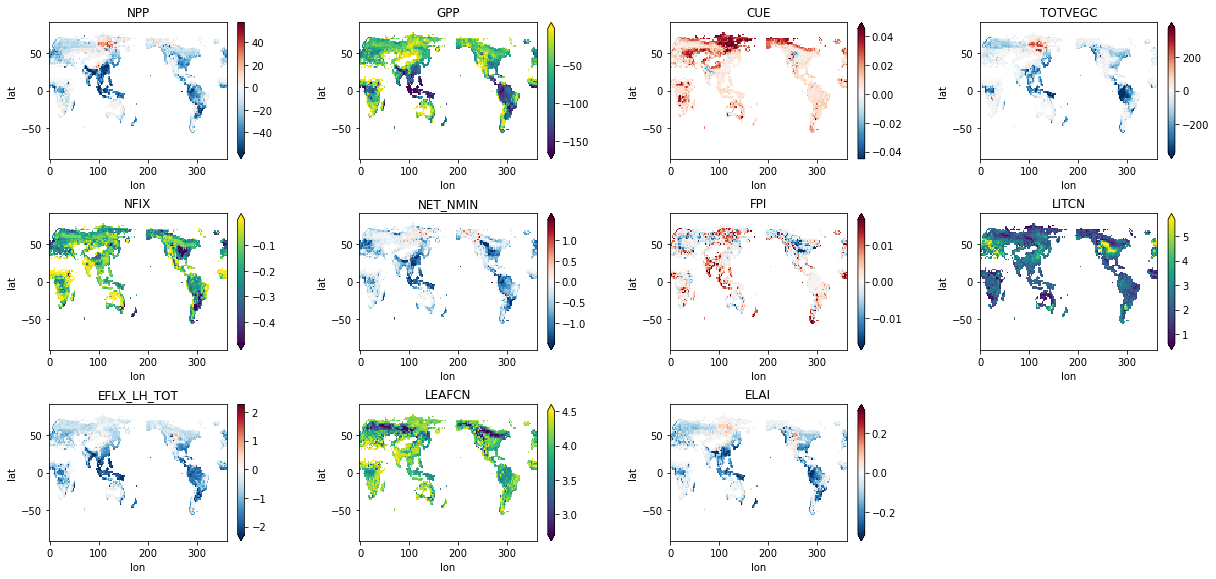

In [52]:
##Global maps

mapVars = ['NPP', 'GPP','CUE', 'TOTVEGC', 'NFIX', 'NET_NMIN', 'FPI', 'LITCN', 'EFLX_LH_TOT','LEAFCN', 'ELAI']
dsAnn = dsAnn.where(dsAnn.GPP.min('time') > minGPP)


plt.figure(figsize = (20,12))
for i in range(11):
    plt.subplot(3,4,1+i)
    z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')[mapVars[i]]# Climatology for last 10 years of data
    z20 = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')[mapVars[i]]
    zdiff = z20 - z
    zdiff = utils.cyclic_dataarray(zdiff)
    lat = zdiff.coords['lat']
    lon = zdiff.coords['lon']
    zdiff.plot(robust = True) ;
     #ann_glob.get(globVars[i]).plot(hue='case')
    plt.title(mapVars[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.4);


In [17]:
z = ann_Awgt.isel(case=1,time=slice(-10,None))#.mean('time')['CUE']
x = dsAnn.isel(case=1,time=slice(-10,None))#.mean('time')['GPP']

ann_Awgt

<xarray.Dataset>
Dimensions:      (time: 165, case: 3)
Coordinates:
  * time         (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
  * case         (case) <U9 'cnSlope0' 'cnSlope20' 'cn_flex_c'
Data variables: (12/14)
    NPP          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    GPP          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    LEAFCN       (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    EFLX_LH_TOT  (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    TOTVEGC      (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    ELAI         (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    ...           ...
    NET_NMIN     (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    FPI          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    NFIX         (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    CUE          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    WUE          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    LITCN        (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>

In [18]:
### Zoom in on FPI plot

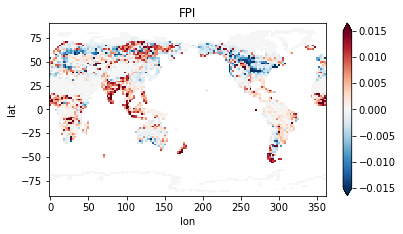

In [19]:
mapVars = [ 'FPI']

plt.figure(figsize = (6,4))
for i in range(1):
    plt.subplot(1,1,1+i)
    z = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')[mapVars[i]]# Climatology for last 10 years of data
    z20 = dsAnn.isel(case=2,time=slice(-10,None)).mean('time')[mapVars[i]]
    zdiff = z - z20
    zdiff = utils.cyclic_dataarray(zdiff)
    lat = zdiff.coords['lat']
    lon = zdiff.coords['lon']
    zdiff.plot(robust = True) ;
     #ann_glob.get(globVars[i]).plot(hue='case')
    plt.title(mapVars[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.4);



In [ ]:
# Plot global LAI, summer difference last 10 years

# dsMax = ds.ELAI.where(ds.GPP.groupby('time.year')).idxmax('time')
# print(dsMax)

##Calculate seasonal means
leafYear_0 = ds.resample(time='QS-DEC').max().isel(time=slice(0,-1))
leaf_summer = leafYear_0.where(leafYear_0.time['time.month']==6, drop=True)

#area weighted mean
leaf_summer2 = (leaf_summer * area_wgt).sum(dim=('lat', 'lon'))
leaf_summer2 = leaf_summer2.isel(case = [0,1])

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
leaf_summer2.ELAI.plot(hue = 'case');

plt.subplot(1,2,2)
y = leaf_summer.isel(case=0,time=slice(-10,None)).mean('time')['ELAI']# Climatology for last 10 years of data
y20 = leaf_summer.isel(case=1,time=slice(-10,None)).mean('time')['ELAI']
ydiff = y20 - y
ydiff = utils.cyclic_dataarray(ydiff)
lat = ydiff.coords['lat']
lon = ydiff.coords['lon']
ydiff.plot(robust = True) ;




/glade/work/ehauser/opt/miniconda/envs/analysis/lib/python3.10/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [ ]:
## Climate feedbacks plots
# include latent heat flux, LAI, GPP, WUE
ClimVars = ['GPP', 'EFLX_LH_TOT', 'WUE']
SummerVar = ['ELAI']

plt.figure(figsize=(9,4))

for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ann_glob_sub.get(ClimVars[i]).plot(hue='case', ax = ax[0]);
    plt.title(ClimVars[i]);
    z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')[ClimVars[i]]# Climatology for last 10 years of data
    z20 = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')[ClimVars[i]]
    zdiff = z20 - z
    zdiff = utils.cyclic_dataarray(zdiff)
    lat = zdiff.coords['lat']
    lon = zdiff.coords['lon']
    if ClimVars[i] == 'EFLX_LH_TOT':
        zdiff.plot(robust = True, ax = ax[1], cmap = 'RdBu_r') ;
    else: 
        zdiff.plot(robust = True, ax = ax[1], cmap = 'Blues_r') ;
    plt.title(ClimVars[i]);

for i in range(1):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    leaf_summer2.get(SummerVar[i]).plot(hue='case', ax = ax[0]);
    plt.title(SummerVar[i]);
        
    z = leaf_summer.isel(case=0,time=slice(-10,None)).mean('time')[SummerVar[i]]# Climatology for last 10 years of data
    z20 = leaf_summer.isel(case=1,time=slice(-10,None)).mean('time')[SummerVar[i]]
    zdiff = z20 - z
    zdiff = utils.cyclic_dataarray(zdiff)
    lat = zdiff.coords['lat']
    lon = zdiff.coords['lon']
    zdiff.plot(robust = True, ax = ax[1]) ;
    plt.title(SummerVar[i]);


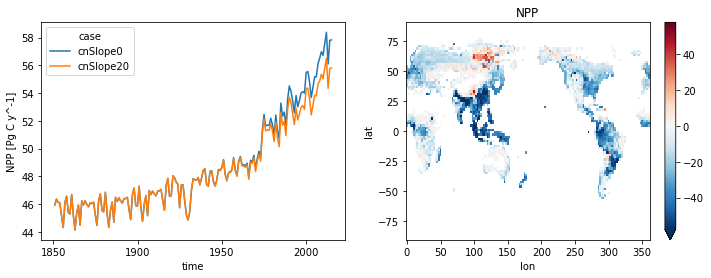

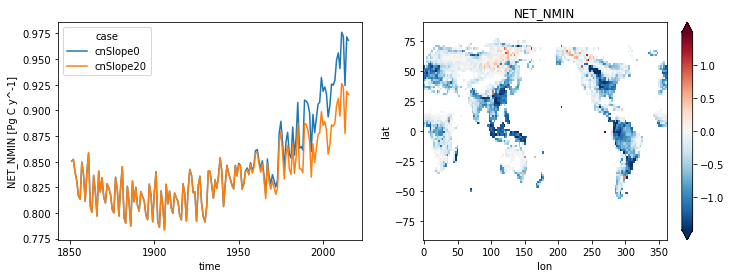

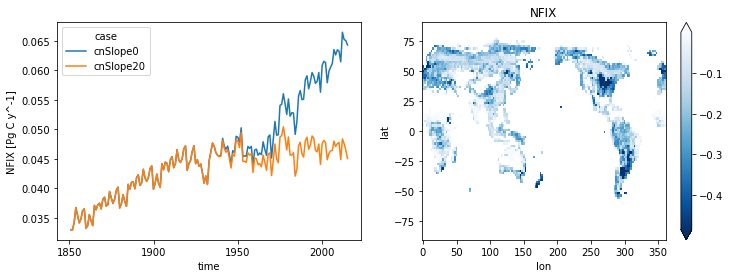

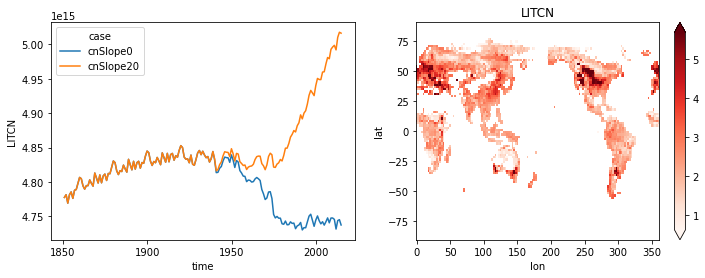

In [55]:
## Ecosystem feedback plots
# Include NPP, Nmin, Nfix, LITTERCN
EcoVars = ['NPP', 'NET_NMIN', 'NFIX', 'LITCN']
minVal = 0
#EcoVars[i] = dsAnn.GPP.where(dsAnn.GPP.min('time') > minGPP)

for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ann_glob_sub.get(EcoVars[i]).plot(hue='case', ax = ax[0]);
    plt.title(EcoVars[i]);
        
    z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')[EcoVars[i]]# Climatology for last 10 years of data
    z20 = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')[EcoVars[i]]
    zdiff = z20 - z
    zdiff = utils.cyclic_dataarray(zdiff)
    lat = zdiff.coords['lat']
    lon = zdiff.coords['lon']
    if EcoVars[i] == 'NFIX':
        zdiff.plot(robust = True, ax = ax[1], cmap = 'Blues_r') ;
    if EcoVars[i] == 'LITCN':
        zdiff.plot(robust = True, ax = ax[1], cmap = 'Reds') ;
    if EcoVars[i] == 'NPP':
        zdiff.plot(robust = True, ax = ax[1], cmap = 'RdBu_r') ;
    if EcoVars[i] == 'NET_NMIN':
        zdiff.plot(robust = True, ax = ax[1], cmap = 'RdBu_r') ;
    plt.title(EcoVars[i]);